# JamUNet model trained with the spatial dataset - training and validation

This notebook was used for training and validating the model.

In [1]:
# # move to root directory

%cd ..

c:\Users\piete\OneDrive\Documenten\DSAIE MORPH\jamunet-morpho-braided


In [2]:
# reload modules to avoid restarting the notebook every time these are updated

%load_ext autoreload
%autoreload 2

In [3]:
# import modules 

import torch
import joblib
import copy

from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

from model.train_eval import * 
from preprocessing.dataset_generation import create_full_dataset
from preprocessing.dataset_generation import combine_datasets
from postprocessing.save_results import *
from postprocessing.plot_results import *

import sys
sys.path.append('model/')
from Lazydata import LazyDataset, build_samples

# enable interactive widgets in Jupyter Notebook
%matplotlib inline
%matplotlib widget

In [4]:
# set the device where operations are performed
# if only one GPU is present you might need to remove the index "0" 
# torch.device('cuda:0') --> torch.device('cuda') / torch.cuda.get_device_name(0) --> torch.cuda.get_device_name() 

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("CUDA Device Count: ", torch.cuda.device_count())
    print("CUDA Device Name: ", torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    
print(f'Using device: {device}')

CUDA Device Count:  1
CUDA Device Name:  NVIDIA GeForce RTX 3070
Using device: cuda:0


In [5]:
import os
num_cpus = os.cpu_count()  # total logical cores
print("Logical CPU cores:", num_cpus)

Logical CPU cores: 16


In [6]:
# set common keys required for functions

train = 'training'
val = 'validation'
test = 'testing'

In [7]:
import os
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\piete\OneDrive\Documenten\DSAIE MORPH\jamunet-morpho-braided


In [8]:
import os
import os
print("Working directory:", os.getcwd())

Working directory: c:\Users\piete\OneDrive\Documenten\DSAIE MORPH\jamunet-morpho-braided


In [9]:
# import os, glob, re
# import numpy as np
# import torch
# from torch.utils.data import Dataset
# from PIL import Image

# # keep your combine_datasets, create_list_images, create_datasets as is


# def _extract_year_from_path(path: str) -> str:
#     base = os.path.basename(path)
#     m = re.search(r"\d{4}", base)
#     if m is None:
#         raise ValueError(f"Could not extract year from: {base}")
#     return m.group(0)


# def _build_tiff_path_from_npy(tgt_npy_path: str,
#                               reach_folder: str,
#                               target_root: str) -> str:
#     year = _extract_year_from_path(tgt_npy_path)
#     tiff_dir = os.path.join(target_root, reach_folder)

#     if not os.path.isdir(tiff_dir):
#         raise FileNotFoundError(f"Target directory not found: {tiff_dir}")

#     tiff_paths = sorted(
#         glob.glob(os.path.join(tiff_dir, f"{year}_*.tif"))
#         + glob.glob(os.path.join(tiff_dir, f"{year}_*.tiff"))
#     )

#     if len(tiff_paths) == 0:
#         raise FileNotFoundError(
#             f"No tiffs found for year {year} in {tiff_dir}"
#         )
#     if len(tiff_paths) > 1:
#         raise ValueError(
#             f"Expected 1 tiff for year {year} in {tiff_dir}, "
#             f"found {len(tiff_paths)}: {tiff_paths}"
#         )

#     return tiff_paths[0]


# def build_samples(
#     train_val_test: str,
#     dir_folders: str = r"data\satellite\preprocessed_PIETER",
#     target_root: str = r"data\satellite\dataset_month3",
#     year_target: int = 5,
#     scaled_classes: bool = True,
# ):
#     """
#     Build the list of (inp_paths, tiff_path) for a given split ('training', 'validation', 'test').

#     This is exactly what your LazyDataset._init_ was doing before,
#     just extracted to a standalone function so it runs only once.
#     """
#     samples = []

#     for folder in os.listdir(dir_folders):
#         # e.g. folder = "JRC_GSW1_4_MonthlyHistory_training_r3"
#         if train_val_test in folder:
#             reach_folder = folder
#             reach_id = int(folder.split("_r", 1)[1])

#             inputs, targets = combine_datasets(
#                 train_val_test,
#                 reach_id,
#                 year_target=year_target,
#                 dir_folders=dir_folders,
#                 scaled_classes=scaled_classes,
#             )

#             for inp_paths, tgt_npy_path in zip(inputs, targets):
#                 tiff_path = _build_tiff_path_from_npy(
#                     tgt_npy_path, reach_folder, target_root
#                 )
#                 samples.append((inp_paths, tiff_path))

#     return samples

In [10]:
# # adjust these strings if your folders use e.g. "train"/"val"/"test"
# train_samples = build_samples(
#     train_val_test="training",
#     dir_folders=r"data\satellite\preprocessed_PIETER",
#     target_root=r"data\satellite\dataset_month3",
#     year_target=5,
#     scaled_classes=True,
# )

# val_samples = build_samples(
#     train_val_test="validation",
#     dir_folders=r"data\satellite\preprocessed_PIETER",
#     target_root=r"data\satellite\dataset_month3",
#     year_target=5,
#     scaled_classes=True,
# )

# test_samples = build_samples(
#     train_val_test="testing",
#     dir_folders=r"data\satellite\preprocessed_PIETER",
#     target_root=r"data\satellite\dataset_month3",
#     year_target=5,
#     scaled_classes=True,
# )

In [11]:
# class LazyDataset(Dataset):
#     def __init__(self, samples, dtype=torch.float32):
#         self.samples = samples      # list of (inp_paths, tiff_path)
#         self.dtype = dtype

#     def __len__(self):
#         return len(self.samples)

#     def _getitem__(self, idx):
#         inp_paths, tiff_path = self.samples[idx]

#         # ---------- INPUT FROM .NPY ----------
#         xs = [np.load(p, mmap_mode="r") for p in inp_paths]   # each: (12, H, W)
#         x_np = np.stack(xs, axis=0)                           # (T, 12, H, W)

#         if x_np.ndim != 4:
#             raise ValueError(f"Expected (T,12,H,W), got {x_np.shape}")

#         T, M, H, W = x_np.shape
#         x_np = x_np.reshape(T * M, H, W)                      # (C, H, W)

#         # ---------- TARGET FROM .TIFF (PIL) ----------
#         if not os.path.exists(tiff_path):
#             raise FileNotFoundError(f"Missing TIFF: {tiff_path}")

#         with Image.open(tiff_path) as img:
#             y_np = np.array(img)

#         if y_np.ndim == 3:
#             y_np = y_np[:, :, 0]

#         x = torch.from_numpy(x_np).to(self.dtype)

#         label = torch.from_numpy(y_np).long()
#         valid_mask = (label != 0).float()
#         y_bin = (label == 2).long()

#         return x, y_bin, valid_mask

In [12]:
# dtype = torch.float32  # or whatever you use

# train_ds = LazyDataset(train_samples, dtype=dtype)
# val_ds   = LazyDataset(val_samples,   dtype=dtype)
# test_ds  = LazyDataset(test_samples,  dtype=dtype)

In [13]:
# from torch.utils.data import DataLoader

# batch_size = 1
# num_workers = 0
# pin_memory = False

# train_ds = LazyDataset(train_samples, dtype=torch.float32)

# train_loader = DataLoader(
#     train_ds,
#     batch_size=batch_size,
#     shuffle=False,
#     num_workers=num_workers,
#     pin_memory=pin_memory,
# )

# batch = next(iter(train_loader))   # take first batch only
# x, y_bin, valid_mask = batch

# print("x shape:", x.shape)

# sample = x[0]
# size_mb = sample.numel() * sample.element_size() / (1024**2)

# print("x bytes per sample:", size_mb, "MB")

**<span style="color:red">Attention!</span>** 
\
Uncomment the next cells if larger training, validation, and testing datasets are needed. These cells load all months datasets (January, February, March, and April) and then merge them into one dataset. 
\
Keep in mind that due to memory constraints, it is likely that not all four datasets can be loaded. 
\
Make sure to load the training, validation, and testing datasets in different cells to reduce memory issues.

In [14]:
# dataset_jan = r'data\satellite\dataset_month1'
# dataset_feb = r'data\satellite\dataset_month2'
# dataset_mar = r'data\satellite\dataset_month3'
# dataset_apr = r'data\satellite\dataset_month4'

# dtype=torch.float32

In [15]:
# inputs_train_jan, targets_train_jan = create_full_dataset(train, dir_folders=dataset_jan, device=device, dtype=dtype).tensors
# inputs_train_feb, targets_train_feb = create_full_dataset(train, dir_folders=dataset_feb, device=device, dtype=dtype).tensors
# inputs_train_mar, targets_train_mar = create_full_dataset(train, dir_folders=dataset_mar, device=device, dtype=dtype).tensors
# inputs_train_apr, targets_train_apr = create_full_dataset(train, dir_folders=dataset_apr, device=device, dtype=dtype).tensors

# inputs_train = torch.cat((inputs_train_jan, inputs_train_feb, inputs_train_mar, inputs_train_apr))
# targets_train = torch.cat((targets_train_jan, targets_train_feb, targets_train_mar, targets_train_apr))
# train_set = TensorDataset(inputs_train, targets_train)

In [16]:
# inputs_val_jan, targets_val_jan = create_full_dataset(val, dir_folders=dataset_jan, device=device, dtype=dtype).tensors
# inputs_val_feb, targets_val_feb = create_full_dataset(val, dir_folders=dataset_feb, device=device, dtype=dtype).tensors
# inputs_val_mar, targets_val_mar = create_full_dataset(val, dir_folders=dataset_mar, device=device, dtype=dtype).tensors
# inputs_val_apr, targets_val_apr = create_full_dataset(val, dir_folders=dataset_apr, device=device, dtype=dtype).tensors

# inputs_val = torch.cat((inputs_val_jan, inputs_val_feb, inputs_val_mar, inputs_val_apr))
# targets_val = torch.cat((targets_val_jan, targets_val_feb, targets_val_mar, targets_val_apr))
# val_set = TensorDataset(inputs_val, targets_val)

In [17]:
# inputs_test_jan, targets_test_jan = create_full_dataset(test, dir_folders=dataset_jan, device=device, dtype=dtype).tensors
# inputs_test_feb, targets_test_feb = create_full_dataset(test, dir_folders=dataset_feb, device=device, dtype=dtype).tensors
# inputs_test_mar, targets_test_mar = create_full_dataset(test, dir_folders=dataset_mar, device=device, dtype=dtype).tensors
# inputs_test_apr, targets_test_apr = create_full_dataset(test, dir_folders=dataset_apr, device=device, dtype=dtype).tensors

# inputs_test = torch.cat((inputs_test_jan, inputs_test_feb, inputs_test_mar, inputs_test_apr))
# targets_test = torch.cat((targets_test_jan, targets_test_feb, targets_test_mar, targets_test_apr))
# test_set = TensorDataset(inputs_test, targets_test)

**<span style="color:red">Attention!</span>** 
\
It is not needed to scale and normalize the dataset as the pixel values are already $[0, 1]$.
\
If scaling and normalization are performed anyways, then **the model inputs have to be changed** as the normalized datasets are used.

In [18]:
# normalize inputs and targets using the training dataset

# scaler_x, scaler_y = scaler(train_set)

# normalized_train_set = normalize_dataset(train_set, scaler_x, scaler_y)
# normalized_val_set = normalize_dataset(val_set, scaler_x, scaler_y)
# normalized_test_set = normalize_dataset(test_set, scaler_x, scaler_y)

In [19]:
# save scalers to be loaded in seperate notebooks (i.e., for testing the model)
# should not change unless seed is changed or augmentation increased (randomsplit changes)

# joblib.dump(scaler_x, r'model\scalers\scaler_x.joblib')
# joblib.dump(scaler_y, r'model\scalers\scaler_y.joblib')

In [20]:
# # load JamUNet architecture

# from model.st_unet.st_unet import *

# # n_channels = train_set[0][0].shape[0]
# n_channels = 48
# n_classes = 2
# init_hid_dim = 8
# kernel_size = 3
# pooling = 'max'

# model = UNet3D(n_channels=n_channels, n_classes=n_classes, init_hid_dim=init_hid_dim, 
#                kernel_size=kernel_size, pooling=pooling, bilinear=False, drop_channels=False)

In [21]:
# print model architecture

# model

In [22]:
# # print total number of parameters and model size

# num_parameters = sum(p.numel() for p in model.parameters())
# print(f"Number of parameters: {num_parameters:.2e}")
# model_size_MB = num_parameters * 4 / (1024 ** 2)  # assuming float32 precision
# print(f"Model size: {model_size_MB:.2f} MB")

**<span style="color:red">Attention!</span>** 
\
Since it is not needed to scale and normalize the dataset (see above), the input for the Data Loader are not the normalized datasets.
\
If normalization is performed, the normalized datasets become the inputs to the model.

In [23]:
# to make it faster
import torch
torch.backends.cudnn.benchmark = True

In [24]:
# # hyperparameters
# learning_rate = 0.05
# batch_size = 16
# num_epochs = 10
# water_threshold = 0.5
# physics = False    # no physics-induced loss terms in the training loss if False
# alpha_er = 1e-4    # needed only if physics=True
# alpha_dep = 1e-4   # needed only if physics=True

# # optimizer to train the model with backpropagation
# optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# # scheduler for decreasing the learning rate 
# # every tot epochs (step_size) with given factor (gamma)
# step_size = 3     # set to None to remove the scheduler
# gamma = 0.75       # set to None to remove the scheduler
# if (step_size and gamma) is not None:
#     scheduler = StepLR(optimizer, step_size = step_size, gamma = gamma)


# train_loader = DataLoader(
#     train_ds,
#     batch_size=batch_size,
#     shuffle=True,        # shuffle only train
#     num_workers=0,       # start with 0; later you can try 1/2 if it behaves
#     pin_memory=False,
# )

# val_loader = DataLoader(
#     val_ds,
#     batch_size=batch_size,
#     shuffle=False,       # no shuffle for validation
#     num_workers=0,       # usually 0–1 is enough (no augmentation)
#     pin_memory=False,
# )

# test_loader = DataLoader(
#     test_ds,
#     batch_size=batch_size,
#     shuffle=False,       # never shuffle test
#     num_workers=0,       # same here
#     pin_memory=False,
# )

In [25]:
import copy
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_training():
    train_samples = build_samples(
        train_val_test="training",
        dir_folders=r"data\satellite\preprocessed_PIETER",
        target_root=r"data\satellite\dataset_month3",
        year_target=5,
        scaled_classes=True,
    )

    train_ds = LazyDataset(train_samples, dtype=torch.float32)

    val_samples = build_samples(
        train_val_test="validation",
        dir_folders=r"data\satellite\preprocessed_PIETER",
        target_root=r"data\satellite\dataset_month3",
        year_target=5,
        scaled_classes=True,
    )

    val_ds = LazyDataset(val_samples, dtype=torch.float32)


    # ----- model -----
    from model.st_unet.st_unet import UNet3D

    n_channels = 39
    n_classes = 2
    init_hid_dim = 8
    kernel_size = 3
    pooling = "max"

    model = UNet3D(
        n_channels=n_channels,
        n_classes=n_classes,
        init_hid_dim=init_hid_dim,
        kernel_size=kernel_size,
        pooling=pooling,
        bilinear=False,
        drop_channels=False,
    ).to(device)

    # ----- hyperparameters -----
    learning_rate = 0.05
    batch_size = 16
    num_epochs = 4
    water_threshold = 0.5
    physics = False
    alpha_er = 1e-4
    alpha_dep = 1e-4

    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    step_size = 4
    gamma = 0.75
    scheduler = None
    if (step_size and gamma) is not None:
        scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    # ----- dataloaders -----
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=False,
        persistent_workers=True,
        prefetch_factor=2,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        pin_memory=False,
        persistent_workers=True,
        prefetch_factor=1,
    )

    # ----- training loop -----
    train_losses, val_losses = [], []
    accuracies, precisions, recalls, f1_scores, csi_scores = [], [], [], [], []
    loss_f = "BCE"
    loss_er_dep = "Huber"

    best_loss = None
    best_recall = None
    best_model = None
    best_model_recall = None
    count = 0

    for epoch in range(1, num_epochs + 1):
        if scheduler is not None:
            scheduler.step()

        train_loss = training_unet(
            model,
            train_loader,
            optimizer,
            water_threshold=water_threshold,
            device=device,
            loss_f=loss_f,
            physics=physics,
            alpha_er=alpha_er,
            alpha_dep=alpha_dep,
            loss_er_dep=loss_er_dep,
        )

        val_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_csi_score = validation_unet(
            model,
            val_loader,
            device=device,
            loss_f=loss_f,
            water_threshold=water_threshold,
        )

        if epoch == 1:
            best_loss = val_loss
            best_recall = val_recall

        if val_loss <= best_loss:
            best_model = copy.deepcopy(model)
            best_loss = val_loss
            best_epoch = epoch
            count = 0

        if val_recall >= best_recall:
            best_model_recall = copy.deepcopy(model)
            best_recall = val_recall
            best_epoch = epoch
            count = 0

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(val_accuracy)
        precisions.append(val_precision)
        recalls.append(val_recall)
        f1_scores.append(val_f1_score)
        csi_scores.append(val_csi_score)

        count += 1

        print(
            f"Epoch: {epoch} | "
            f"Training loss: {train_loss:.2e}, Validation loss: {val_loss:.2e}, Best validation loss: {best_loss:.2e} "
            f"| Metrics: Accuracy: {val_accuracy:.3f}, Precision: {val_precision:.3f}, "
            f"Recall: {val_recall:.3f}, F1-score: {val_f1_score:.3f}, "
            f"CSI-score: {val_csi_score:.3f}, Best recall: {best_recall:.3f}"
        )
        if scheduler is not None:
            print(f"Current learning rate: {scheduler.get_last_lr()[0]}")

    return {
        "model": model,
        "best_model": best_model,
        "best_model_recall": best_model_recall,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "accuracies": accuracies,
        "precisions": precisions,
        "recalls": recalls,
        "f1_scores": f1_scores,
        "csi_scores": csi_scores,
    }

In [26]:
if __name__ == "__main__":
    results = run_training()

Epoch: 1 | Training loss: 2.08e-01, Validation loss: 1.70e-01, Best validation loss: 1.70e-01 | Metrics: Accuracy: 0.929, Precision: 0.605, Recall: 0.156, F1-score: 0.233, CSI-score: 0.138, Best recall: 0.156
Current learning rate: 0.05
Epoch: 2 | Training loss: 1.62e-01, Validation loss: 1.60e-01, Best validation loss: 1.60e-01 | Metrics: Accuracy: 0.933, Precision: 0.559, Recall: 0.403, F1-score: 0.457, CSI-score: 0.304, Best recall: 0.403
Current learning rate: 0.05
Epoch: 3 | Training loss: 1.53e-01, Validation loss: 1.62e-01, Best validation loss: 1.60e-01 | Metrics: Accuracy: 0.930, Precision: 0.526, Recall: 0.551, F1-score: 0.535, CSI-score: 0.369, Best recall: 0.551
Current learning rate: 0.05
Epoch: 4 | Training loss: 1.49e-01, Validation loss: 1.45e-01, Best validation loss: 1.45e-01 | Metrics: Accuracy: 0.934, Precision: 0.575, Recall: 0.419, F1-score: 0.484, CSI-score: 0.322, Best recall: 0.551
Current learning rate: 0.037500000000000006


In [27]:
model = results["model"]
best_model = results["best_model"]
best_model_recall = results["best_model_recall"]
train_losses = results["train_losses"]
val_losses = results["val_losses"]
accuracies = results["accuracies"]
precisions = results["precisions"]
recalls = results["recalls"]
f1_scores = results["f1_scores"]
csi_scores = results["csi_scores"]

In [35]:
test_samples = build_samples(
    train_val_test="testing",
    dir_folders=r"data\satellite\preprocessed_PIETER",
    target_root=r"data\satellite\dataset_month3",
    year_target=5,
    scaled_classes=True,
)

test_set  = LazyDataset(test_samples, dtype=torch.float32)


In [36]:
metrics = [accuracies, precisions, recalls, f1_scores, csi_scores]

loss_f = "BCE"

In [37]:
# store training and validation losses and metrics to be stored in a .csv file for later postprocessing
# always check the dataset month key

save_losses_metrics(train_losses, val_losses, metrics, 'spatial', model, 3, dir_output=r'model\losses_metrics')

model\losses_metrics\UNet3D_spatial_losses&metrics_month3_4dwns_Noneihiddim_Noneker_Nonepool_Noneilr_Nonebatch_Noneepochs_Nonewthr.csv


**<span style="color:red">Attention!</span>** 
\
Always remember to rename the <code>save_path</code> file before running the whole notebook to avoid overwrting it.

In [38]:
# save model with min validation loss
# always check the dataset month key

save_model_path(model=best_model, spatial_temporal='spatial', val_losses='loss') 

TypeError: save_model_path() missing 2 required positional arguments: 'train_losses' and 'metrics'

In [ ]:
# save model with max recall
# always check the dataset month key

save_model_path(best_model_recall, 'spatial', 'recall', 3) 

In [ ]:
# test the min loss model - average loss and metrics

model_loss = copy.deepcopy(best_model)
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_csi_score = validation_unet(model_loss, test_loader, device=device, loss_f = loss_f)

print(f'Average metrics for test dataset using model with best validation loss:\n\n\
{loss_f} loss:          {test_loss:.3e}\n\
Accuracy:          {test_accuracy:.3f}\n\
Precision:         {test_precision:.3f}\n\
Recall:            {test_recall:.3f}\n\
F1 score:          {test_f1_score:.3f}\n\
CSI score:         {test_csi_score:.3f}')

ValueError: expected 4D input (got 3D input)

In [ ]:
# test the max recall model - average loss and metrics

model_recall = copy.deepcopy(best_model_recall)
test_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_csi_score = validation_unet(model_recall, test_loader, device=device, loss_f = loss_f)

print(f'Average metrics for test dataset using model with best validation recall:\n\n\
{loss_f} loss:          {test_loss:.3e}\n\
Accuracy:          {test_accuracy:.3f}\n\
Precision:         {test_precision:.3f}\n\
Recall:            {test_recall:.3f}\n\
F1 score:          {test_f1_score:.3f}\n\
CSI score:         {test_csi_score:.3f}')

ATTENTION: the argument `save_name` is not specified: the plot is not saved.


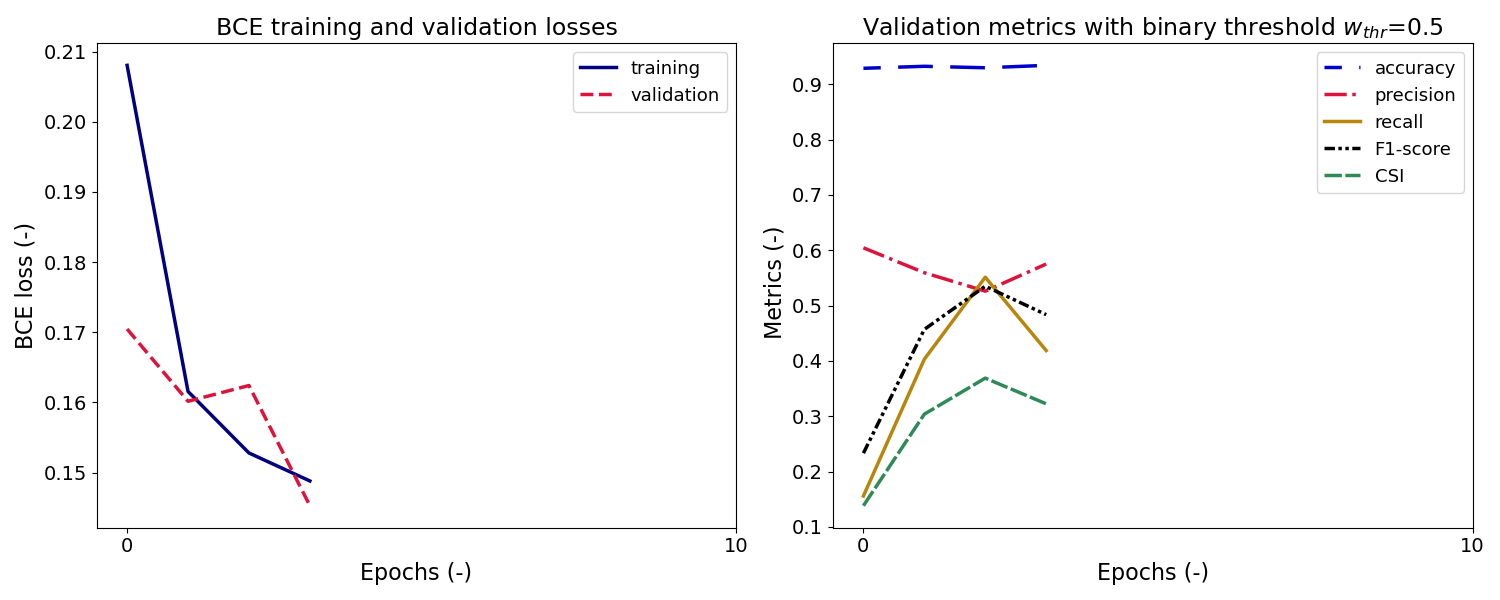

In [52]:
plot_losses_metrics(train_losses, val_losses, metrics, best_model_recall, loss_f=loss_f)


=== DEBUG sample 18 ===
target_img unique + counts: [(0, 449547), (1, 50453)]
pred_mask unique + counts: [(0.0, 448714), (1.0, 51286)]
diff_final unique + counts: [(0, 433061), (1, 34800), (2, 16486), (3, 15653)]


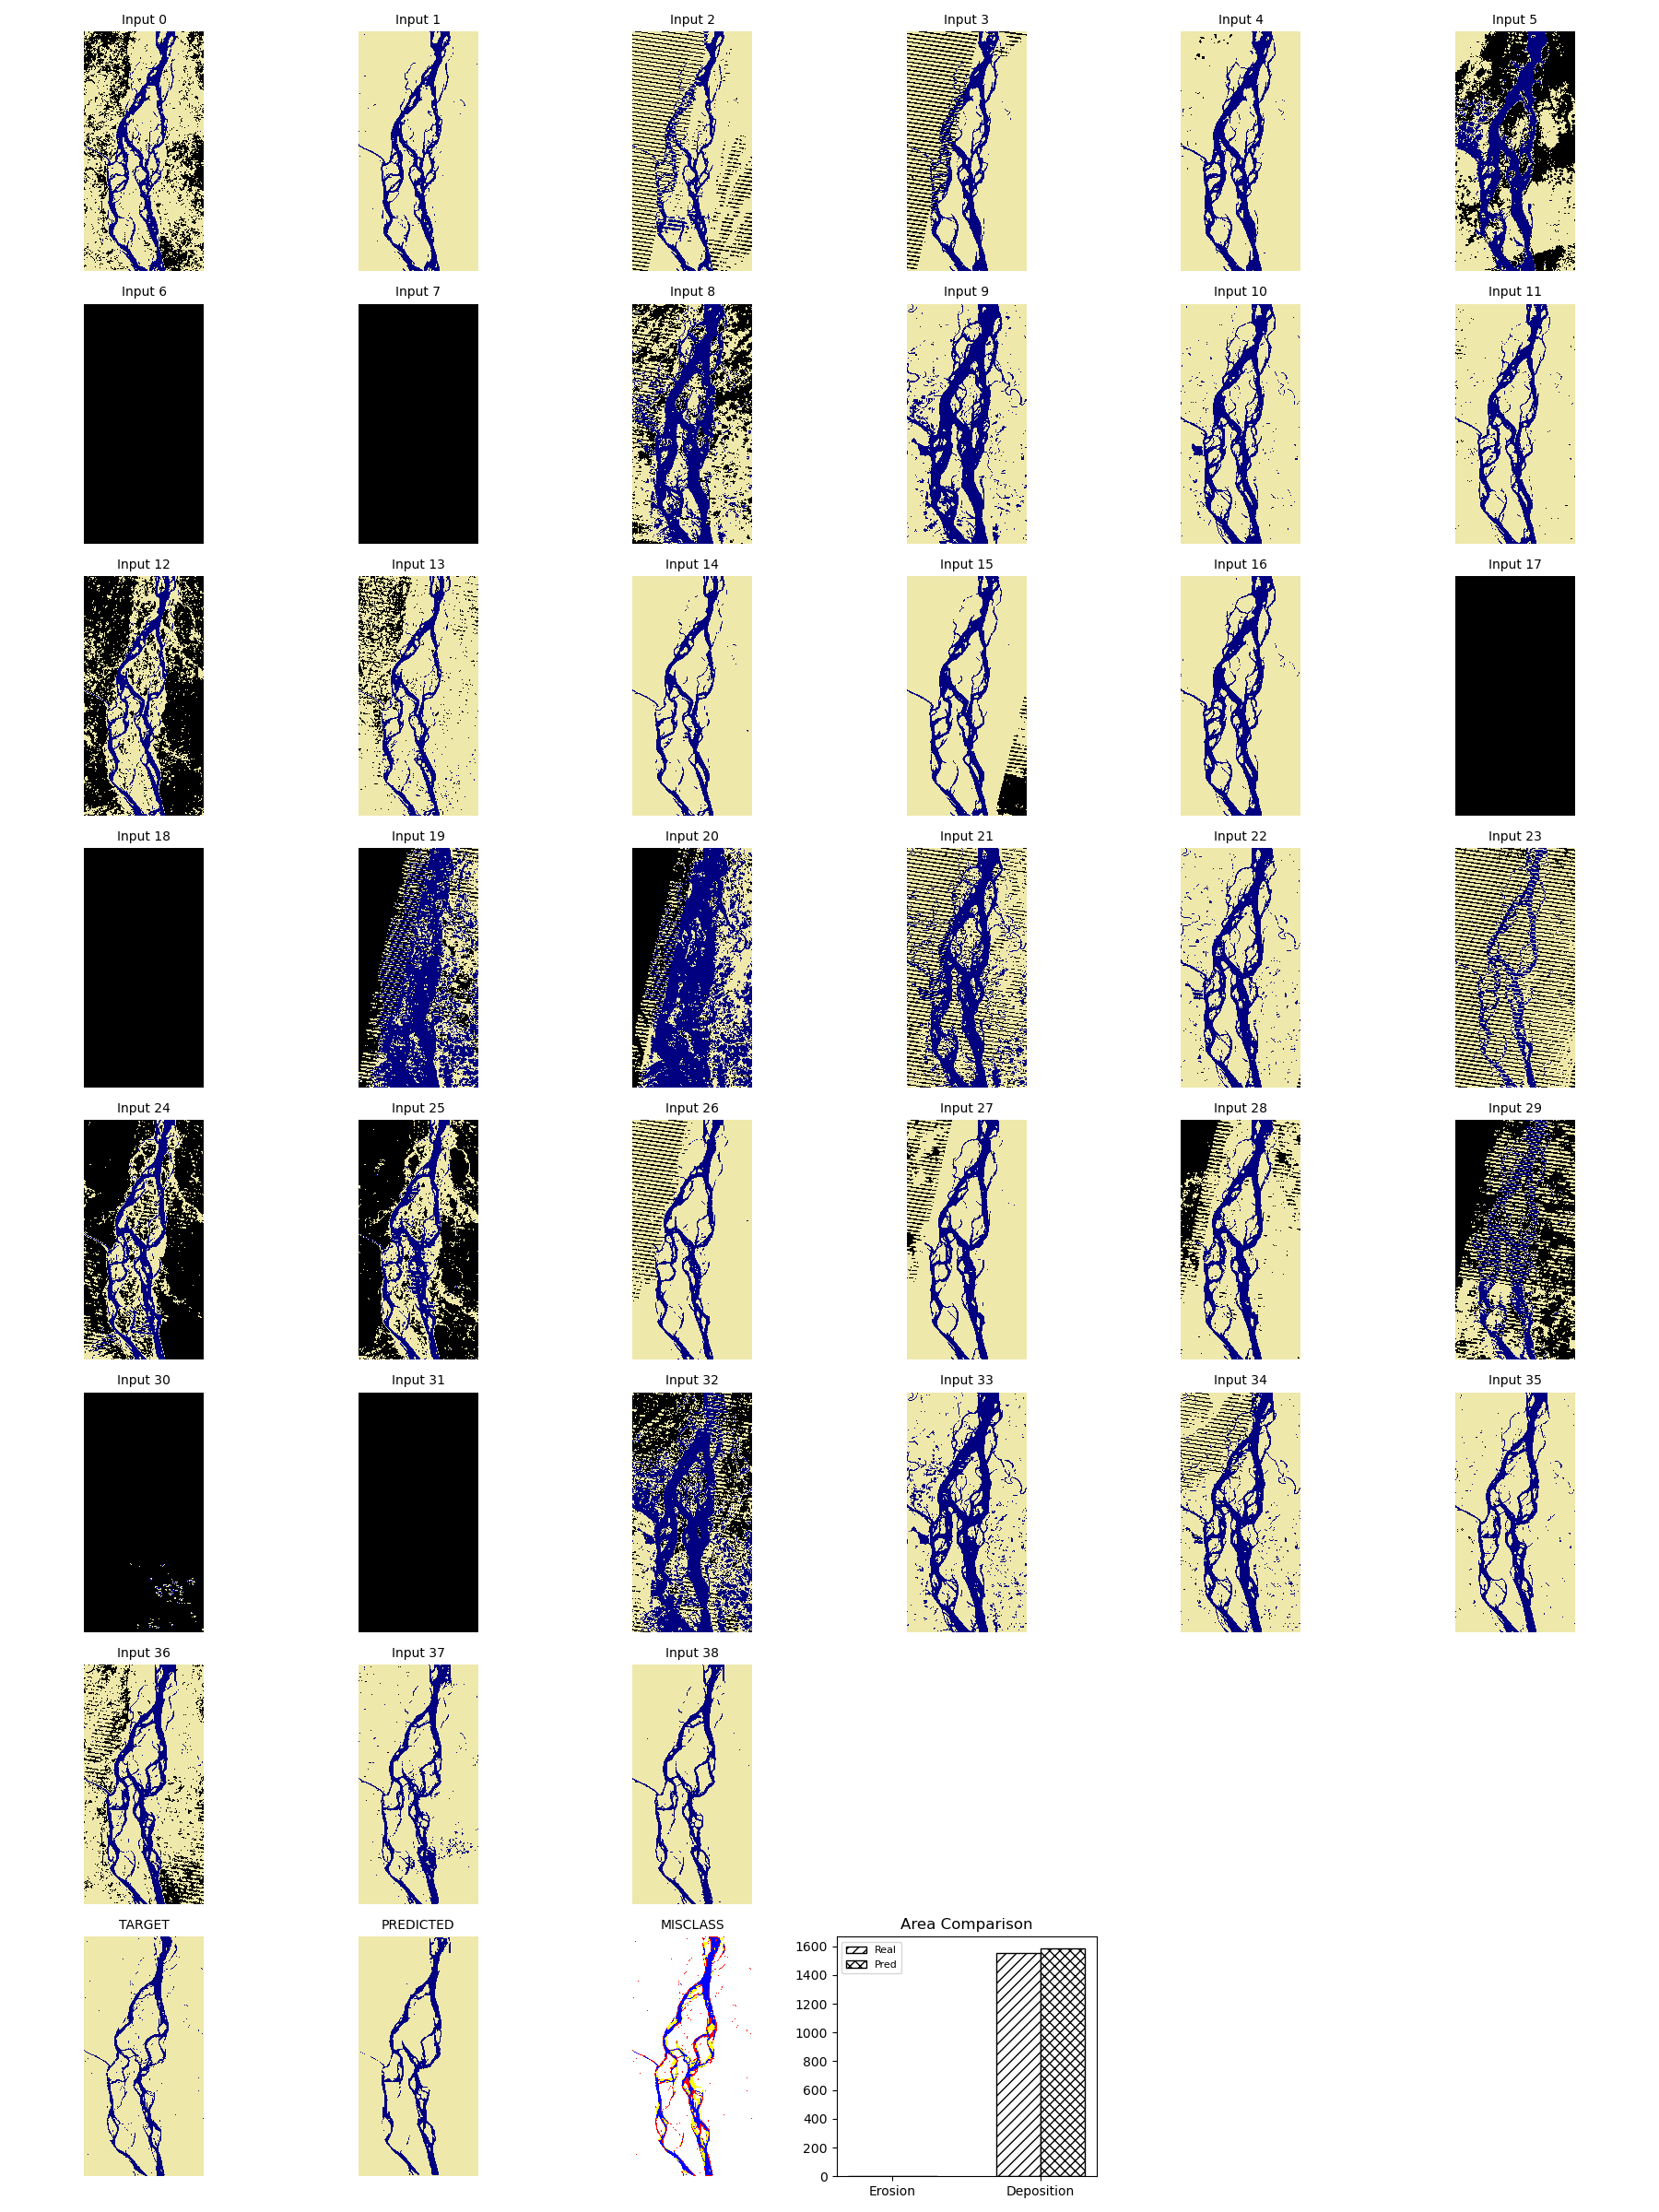

In [44]:
# show_evolution(18, test_set, model_loss)

device = 'cuda:0'
model_loss = model_loss.to(device)

show_all_images(18, test_set, model_loss, device=device)

In [45]:
# show_evolution(18, test_set, model_recall)
show_evolution_nolegend_nn(18, test_set, model_recall, device=device)

NameError: name 'model_recall' is not defined

In [41]:
# show_evolution(18, val_set, model_recall)
show_evolution_nolegend_nn(18, val_set, model_recall, device=device)

NameError: name 'val_set' is not defined

In [ ]:
single_roc_curve(model_loss, test_set, sample=18, device=device);

In [42]:
single_roc_curve(model_recall, test_set, sample=18, device=device);

NameError: name 'model_recall' is not defined

In [ ]:
get_total_roc_curve(model_loss, test_set, device=device);

In [43]:
get_total_roc_curve(model_recall, test_set, device=device);

NameError: name 'model_recall' is not defined

In [ ]:
single_pr_curve(model_loss, test_set, sample=19, device=device)

In [ ]:
# show_evolution(18, test_set, model_loss)
show_evolution_nolegend_nn(18, test_set, model_loss, device=device)